In [1]:
import sqlite3

'''
  Getting the data from pkl files and storing it in a sqlite database
'''

'''
  Tables:
    videos: id, name, path, duration, fps, width, height
    poses: id, video_id, frame_id, category_id, score
    keypoints: id, pose_id, x, y, confidence, order
    bodies: id, x_min, y_min, width, height, idx, pose_id
    instruments: id, name, video_id 
'''

# Create a connection to the database
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Create tables if they don't exist
  c.execute('''CREATE TABLE IF NOT EXISTS videos
                (id TEXT PRIMARY KEY, name TEXT, path TEXT, duration INTEGER, fps INTEGER, width INTEGER, height INTEGER)''')
  c.execute('''CREATE TABLE IF NOT EXISTS poses
                (id INTEGER PRIMARY KEY, frame_id INTEGER, category_id INTEGER, score REAL, video_id TEXT, FOREIGN KEY(video_id) REFERENCES videos(id))''')
  c.execute('''CREATE TABLE IF NOT EXISTS keypoints
                (id INTEGER PRIMARY KEY, x REAL, y REAL, confidence REAL, kp_order INTEGER, pose_id INTEGER, FOREIGN KEY(pose_id) REFERENCES poses(id))''')
  c.execute('''CREATE TABLE IF NOT EXISTS bodies
                (id INTEGER PRIMARY KEY, x_min REAL, y_min REAL, width REAL, height REAL, idx INTEGER, pose_id INTEGER, FOREIGN KEY(pose_id) REFERENCES poses(id))''')
  c.execute('''CREATE TABLE IF NOT EXISTS instruments
                (id INTEGER PRIMARY KEY, name TEXT, video_id TEXT, FOREIGN KEY(video_id) REFERENCES videos(id))''')
  conn.commit()

In [2]:
import pickle

# Load the data from the pkl files
with open('../duet_dataset.pkl', 'rb') as f:
  duet_dataset = pickle.load(f)
duet_dataset

{'acoustic_guitar violin': [['/ext_data2/manhnh/MUSIC_dataset/output/duet/acoustic_guitar violin/1uG4jnhHgAc_0.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/duet-results/1uG4jnhHgAc_0.json',
   ['acoustic_guitar', 'violin']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/duet/acoustic_guitar violin/1uG4jnhHgAc_10.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/duet-results/1uG4jnhHgAc_10.json',
   ['acoustic_guitar', 'violin']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/duet/acoustic_guitar violin/1uG4jnhHgAc_11.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/duet-results/1uG4jnhHgAc_11.json',
   ['acoustic_guitar', 'violin']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/duet/acoustic_guitar violin/1uG4jnhHgAc_12.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/duet-results/1uG4jnhHgAc_12.json',
   ['acoustic_guitar', 'violin']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/duet/acoustic_guitar violin/1uG4jnhHgAc_13.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/duet-r

In [3]:
import os
import cv2
import json

# Load the data from the pkl files to the database
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Insert videos
  for folder in duet_dataset:
    for video in duet_dataset[folder]:
      input = video[0]
      output = video[1]
      instruments = video[2]
      if not os.path.exists(input) or not os.path.exists(output):
        continue
      name = os.path.basename(input)
      path = input
      duration = cv2.VideoCapture(input).get(cv2.CAP_PROP_FRAME_COUNT)
      fps = cv2.VideoCapture(input).get(cv2.CAP_PROP_FPS)
      width = cv2.VideoCapture(input).get(cv2.CAP_PROP_FRAME_WIDTH)
      height = cv2.VideoCapture(input).get(cv2.CAP_PROP_FRAME_HEIGHT)
      c.execute('''INSERT OR IGNORE INTO videos (id, name, path, duration, fps, width, height)
                    VALUES (?, ?, ?, ?, ?, ?, ?)''', (name, name, path, duration, fps, width, height))
      # Insert instruments
      for instrument in instruments:
        c.execute('''INSERT OR IGNORE INTO instruments (name, video_id)
                      VALUES (?, ?)''', (instrument, name))
      print('Inserted video: ', name, duration, fps, width, height)
      # Insert poses
      with open(output, 'rb') as f:
        # Load json output
        poses = json.load(f)
        # Insert poses
        for pose in poses:
          frame_id = pose['image_id']
          category_id = pose['category_id']
          score = pose['score']
          c.execute('''INSERT OR IGNORE INTO poses (frame_id, category_id, score, video_id)
                        VALUES (?, ?, ?, ?)''', (frame_id, category_id, score, name))
          # print('Inserted pose:', frame_id, category_id, score, name)
          # Insert keypoints
          keypoints = pose['keypoints']
          num_joints = int(len(keypoints) / 3)
          pose_id = c.lastrowid
          for j in range(num_joints):
              #Get the x and y coordinates of the joints
              x = keypoints[j*3]
              y = keypoints[j*3+1]
              confidence = keypoints[j*3+2]
              kp_order = j
              c.execute('''INSERT OR IGNORE INTO keypoints (x, y, confidence, kp_order, pose_id)
                            VALUES (?, ?, ?, ?, ?)''', (x, y, confidence, kp_order, pose_id))
          # print('Joints num: ', num_joints)
          x_min = pose['box'][0]
          y_min = pose['box'][1]
          width = pose['box'][2]
          height = pose['box'][3]
          idx = pose['idx']
          c.execute('''INSERT OR IGNORE INTO bodies (x_min, y_min, width, height, pose_id)
                        VALUES (?, ?, ?, ?, ?)''', (x_min, y_min, width, height, idx, pose_id))
          # print('Box: ', x_min, y_min, width, height)
      conn.commit()

Inserted video:  1uG4jnhHgAc_0.mp4 250.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_10.mp4 206.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_11.mp4 192.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_12.mp4 202.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_13.mp4 248.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_14.mp4 234.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_15.mp4 244.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_16.mp4 230.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_17.mp4 216.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_18.mp4 226.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_19.mp4 212.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_1.mp4 200.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_20.mp4 198.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_21.mp4 208.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_22.mp4 194.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_23.mp4 240.0 25.0 640.0 360.0
Inserted video:  1uG4jnhHgAc_24.mp4 250.0 25.0 640.0 360.0

In [45]:
import pickle

# Load the data from the pkl files
with open('../solo_dataset.pkl', 'rb') as f:
  solo_dataset = pickle.load(f)
solo_dataset

{'accordion': [['/ext_data2/manhnh/MUSIC_dataset/output/MUSIC_solo2/accordion/0N26WnKiCIg_0.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/solo-results/0N26WnKiCIg_0.json',
   ['accordion']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/MUSIC_solo2/accordion/0N26WnKiCIg_10.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/solo-results/0N26WnKiCIg_10.json',
   ['accordion']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/MUSIC_solo2/accordion/0N26WnKiCIg_11.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/solo-results/0N26WnKiCIg_11.json',
   ['accordion']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/MUSIC_solo2/accordion/0N26WnKiCIg_12.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/solo-results/0N26WnKiCIg_12.json',
   ['accordion']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/MUSIC_solo2/accordion/0N26WnKiCIg_1.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/solo-results/0N26WnKiCIg_1.json',
   ['accordion']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/MUSIC_solo2/accord

In [47]:
import os
import cv2
import json

# Load the data from the pkl files to the database
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Insert videos
  for folder in solo_dataset:
    for video in solo_dataset[folder]:
      input = video[0]
      output = video[1]
      instruments = video[2]
      if not os.path.exists(input) or not os.path.exists(output):
        continue
      name = os.path.basename(input)
      path = input
      duration = cv2.VideoCapture(input).get(cv2.CAP_PROP_FRAME_COUNT)
      fps = cv2.VideoCapture(input).get(cv2.CAP_PROP_FPS)
      width = cv2.VideoCapture(input).get(cv2.CAP_PROP_FRAME_WIDTH)
      height = cv2.VideoCapture(input).get(cv2.CAP_PROP_FRAME_HEIGHT)
      c.execute('''INSERT OR IGNORE INTO videos (id, name, path, duration, fps, width, height)
                    VALUES (?, ?, ?, ?, ?, ?, ?)''', (name, name, path, duration, fps, width, height))
      # Insert instruments
      for instrument in instruments:
        c.execute('''INSERT OR IGNORE INTO instruments (name, video_id)
                      VALUES (?, ?)''', (instrument, name))
      print('Inserted video: ', name, duration, fps, width, height)
      # Insert poses
      with open(output, 'rb') as f:
        # Load json output
        poses = json.load(f)
        # Insert poses
        for pose in poses:
          frame_id = pose['image_id']
          category_id = pose['category_id']
          score = pose['score']
          c.execute('''INSERT OR IGNORE INTO poses (frame_id, category_id, score, video_id)
                        VALUES (?, ?, ?, ?)''', (frame_id, category_id, score, name))
          # print('Inserted pose:', frame_id, category_id, score, name)
          # Insert keypoints
          keypoints = pose['keypoints']
          num_joints = int(len(keypoints) / 3)
          pose_id = c.lastrowid
          for j in range(num_joints):
              #Get the x and y coordinates of the joints
              x = keypoints[j*3]
              y = keypoints[j*3+1]
              confidence = keypoints[j*3+2]
              kp_order = j
              c.execute('''INSERT OR IGNORE INTO keypoints (x, y, confidence, kp_order, pose_id)
                            VALUES (?, ?, ?, ?, ?)''', (x, y, confidence, kp_order, pose_id))
          # print('Joints num: ', num_joints)
          x_min = pose['box'][0]
          y_min = pose['box'][1]
          width = pose['box'][2]
          height = pose['box'][3]
          idx = pose['idx']
          c.execute('''INSERT OR IGNORE INTO bodies (x_min, y_min, width, height, idx, pose_id)
                        VALUES (?, ?, ?, ?, ?, ?)''', (x_min, y_min, width, height, idx, pose_id))
          # print('Box: ', x_min, y_min, width, height)
      conn.commit()

Inserted video:  0N26WnKiCIg_0.mp4 300.0 29.97002997002997 270.0 360.0
Inserted video:  0N26WnKiCIg_10.mp4 273.0 29.97002997002997 270.0 360.0
Inserted video:  0N26WnKiCIg_11.mp4 289.0 29.97002997002997 270.0 360.0
Inserted video:  0N26WnKiCIg_12.mp4 289.0 29.97002997002997 270.0 360.0
Inserted video:  0N26WnKiCIg_1.mp4 300.0 29.97002997002997 270.0 360.0
Inserted video:  0N26WnKiCIg_2.mp4 256.0 29.97002997002997 270.0 360.0
Inserted video:  0N26WnKiCIg_3.mp4 271.0 29.97002997002997 270.0 360.0
Inserted video:  0N26WnKiCIg_4.mp4 271.0 29.97002997002997 270.0 360.0
Inserted video:  0N26WnKiCIg_5.mp4 287.0 29.97002997002997 270.0 360.0
Inserted video:  0N26WnKiCIg_6.mp4 286.0 29.97002997002997 270.0 360.0
Inserted video:  0N26WnKiCIg_7.mp4 242.0 29.97002997002997 270.0 360.0
Inserted video:  0N26WnKiCIg_8.mp4 258.0 29.97002997002997 270.0 360.0
Inserted video:  0N26WnKiCIg_9.mp4 258.0 29.97002997002997 270.0 360.0
Inserted video:  1LnKd5cuqIc_0.mp4 300.0 29.97002997002997 640.0 360.0
Ins

In [2]:
import sqlite3
# Create index on poses table using the video_id and frame_id
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Delete the index if it exists
  c.execute('''DROP INDEX IF EXISTS poses_video_id_frame_id''')
  c.execute('''CREATE INDEX poses_video_id_frame_id ON poses(video_id, frame_id)''')
  conn.commit()

In [14]:
import sqlite3
# Get the number of bodies in a video
video_bodies = {}
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Count the number of unique idx of the bodies table
  c.execute('''SELECT video_id, COUNT(DISTINCT idx) FROM bodies JOIN poses ON bodies.pose_id = poses.id GROUP BY video_id''')
  for row in c:
    video_bodies[row[0]] = row[1]
video_bodies

{'--IXKwloYLE_0.mp4': 2,
 '--IXKwloYLE_1.mp4': 2,
 '--IXKwloYLE_10.mp4': 2,
 '--IXKwloYLE_2.mp4': 2,
 '--IXKwloYLE_3.mp4': 2,
 '--IXKwloYLE_4.mp4': 2,
 '--IXKwloYLE_5.mp4': 3,
 '--IXKwloYLE_6.mp4': 3,
 '--IXKwloYLE_7.mp4': 2,
 '--IXKwloYLE_8.mp4': 2,
 '--IXKwloYLE_9.mp4': 2,
 '-0gYWIOfqdM_0.mp4': 1,
 '-0gYWIOfqdM_1.mp4': 1,
 '-0gYWIOfqdM_2.mp4': 2,
 '-0gYWIOfqdM_4.mp4': 1,
 '-0gYWIOfqdM_6.mp4': 3,
 '-0gYWIOfqdM_7.mp4': 1,
 '-3V-vUMkHqk_0.mp4': 1,
 '-3V-vUMkHqk_1.mp4': 4,
 '-5CDUnGu3jA_0.mp4': 4,
 '-5CDUnGu3jA_1.mp4': 3,
 '-5CDUnGu3jA_10.mp4': 3,
 '-5CDUnGu3jA_11.mp4': 3,
 '-5CDUnGu3jA_12.mp4': 1,
 '-5CDUnGu3jA_13.mp4': 5,
 '-5CDUnGu3jA_14.mp4': 2,
 '-5CDUnGu3jA_15.mp4': 2,
 '-5CDUnGu3jA_16.mp4': 2,
 '-5CDUnGu3jA_17.mp4': 6,
 '-5CDUnGu3jA_18.mp4': 4,
 '-5CDUnGu3jA_19.mp4': 4,
 '-5CDUnGu3jA_2.mp4': 2,
 '-5CDUnGu3jA_3.mp4': 1,
 '-5CDUnGu3jA_4.mp4': 4,
 '-5CDUnGu3jA_5.mp4': 2,
 '-5CDUnGu3jA_6.mp4': 3,
 '-5CDUnGu3jA_7.mp4': 2,
 '-5CDUnGu3jA_8.mp4': 1,
 '-5CDUnGu3jA_9.mp4': 6,
 '-5MipMQ25cU_

In [14]:
for video in video_bodies.keys():
    if video_bodies[video] == 558:
        print(video)

Vxe4R5qqEPI_0.mp4


In [3]:
import sqlite3
# Get the video that have no poses
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Count the number of unique idx of the bodies table
  c.execute('''SELECT id FROM videos WHERE id NOT IN (SELECT video_id FROM poses)''')
  for row in c:
    print(row[0])

-HLTNgdajqw_0.mp4
4zpGMEalJHk_15.mp4
5GpXUu8cz1c_0.mp4
5GpXUu8cz1c_1.mp4
5GpXUu8cz1c_2.mp4
5GpXUu8cz1c_7.mp4
5GpXUu8cz1c_8.mp4
7kbgi9oNEi0_0.mp4
9MOG4aV-qNU_24.mp4
AP-vB4w_7Ag_0.mp4
G_rINXF-bzg_41.mp4
K_U5-GbPgi0_22.mp4
SPXyBDbGt4s_0.mp4
Ua1zhXvO6Dk_26.mp4
UlZXQqfwhI4_33.mp4
bLjS6E6c0IA_17.mp4
fXjfvEcAV6w_0.mp4
fXjfvEcAV6w_104.mp4
h2oiK1-8U5U_0.mp4
w55jJXSspUo_0.mp4


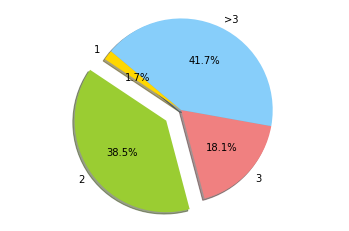

In [5]:
# Display the results into a pie graph and save it
import matplotlib.pyplot as plt
import numpy as np

def plot_pie(video_bodies):
  # Create a pie chart compose of videos with 1, 2, 3, and >3 bodies
  labels = ['1', '2', '3', '>3']
  # Split the videos into groups of 1, 2, 3, and >3 video_bodies
  sizes = [0, 0, 0, 0]
  for video in video_bodies:
    if video_bodies[video] == 1:
      sizes[0] += 1
    elif video_bodies[video] == 2:
      sizes[1] += 1
    elif video_bodies[video] == 3:
      sizes[2] += 1
    else:
      sizes[3] += 1
  colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
  explode = (0.0, 0.2, 0.0, 0.0)
  plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
  plt.axis('equal')
  plt.savefig('../duet_dataset_pie.png')
  plt.show()

plot_pie(video_bodies)

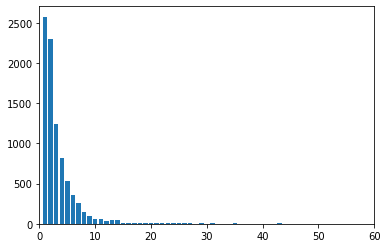

In [15]:
# Display the results into a bar graph and save it
import matplotlib.pyplot as plt
import numpy as np

def plot_bar(video_bodies):
  # Create a bar chart compose from the least amount of bodies to the most amount of bodies
  x = np.arange(len(video_bodies))
  y = video_bodies.values()
  bars = {}
  for val in y:
    if val not in bars:
      bars[val] = 1
    else:
      bars[val] += 1
  plt.bar(*zip(*bars.items()))
  # Limit the x axis to the max number of bodies
  plt.xlim(0, 60)
  plt.show()

plot_bar(video_bodies)

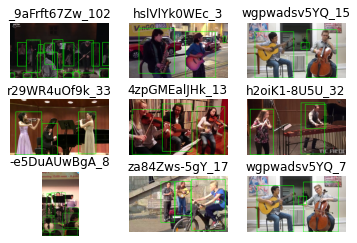

In [16]:
# Display a random sample of the frames with >2 bodies
import random, cv2

def display_random_sample(video_bodies):
  larger_than_2_bodies = []
  with sqlite3.connect('data.db') as conn:
    c = conn.cursor()
    # Get the frames with >2 bodies
    c.execute('''SELECT pose_id, frame_id FROM poses JOIN bodies ON poses.id = bodies.pose_id GROUP BY video_id, frame_id HAVING COUNT(DISTINCT pose_id) > 2''')
    for row in c:
      larger_than_2_bodies.append(row)
  # Get a random sample of the frames with >2 bodies
  random_sample = random.sample(larger_than_2_bodies, 9)
  # plt a grid of num_of_samples frames with >2 bodies
  fig, ax = plt.subplots(3,3)
  for i, row in enumerate(random_sample):
    pose_id = row[0]
    frame_id = int(row[1][:-4])
    # Get the image
    # Get the path and video_id first
    c.execute('''SELECT path, video_id FROM videos JOIN poses ON videos.id = poses.video_id WHERE poses.id = ?''', (pose_id,))
    video_path, video_id = c.fetchone()
    # Get the frame_id-th frame of the video
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = cap.read()
    # Draw the bodies' bounding boxes on the frame
    c.execute('''SELECT x_min, y_min, width, height FROM bodies JOIN poses ON bodies.pose_id = poses.id WHERE video_id = ? AND frame_id = ?''', (video_id, row[1]))
    for r in c:
      x_min = int(r[0])
      y_min = int(r[1])
      width = int(r[2])
      height = int(r[3])
      cv2.rectangle(frame, (x_min, y_min), (x_min+width, y_min+height), (0, 255, 0), 2)
    #  Show the images with the frame_id in the fig
    ax[i//3, i%3].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax[i//3, i%3].set_title(str(os.path.basename(video_path))[:-4])
    ax[i//3, i%3].axis('off')
  plt.savefig('../duet_dataset_sample.png', dpi = 300)
  plt.show()

display_random_sample(video_bodies)

In [2]:
# Get the two most common idx of the bodies table for each video
import sqlite3

idx_count = {}
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Get the two most common idx of the bodies table for each video, also the number of instruments
  c.execute('''SELECT video_id, idx, COUNT(idx) FROM bodies JOIN poses ON bodies.pose_id = poses.id GROUP BY video_id, idx ORDER BY video_id, COUNT(idx) DESC''')
  for row in c:
    if row[0] not in idx_count:
      idx_count[row[0]] = {}
    idx_count[row[0]][row[1]] = row[2]
len(idx_count)

8754

In [3]:
# Get the count of instruments per video
import sqlite3

with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Get the count of instruments per video
  c.execute('''SELECT video_id, COUNT(id) FROM instruments GROUP BY video_id''')
  for row in c:
    if row[0] not in idx_count:
      idx_count[row[0]] = {}
    idx_count[row[0]]['instruments'] = row[1]
len(idx_count)

8820

[1, 2, 3, 'other']
[818.5346375590674, 655.2019953476458, 199.96471818737, 143.29864890591907]


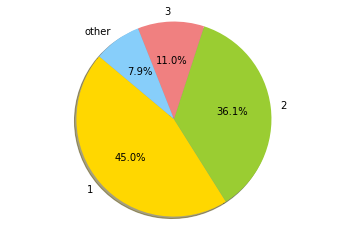

In [10]:
# Plot a pie graph showing the percentage
# of each idx appearences per video
import matplotlib.pyplot as plt
import numpy as np

def plot_appearences(idx_count, compare_to):
  idx_count_more = {}
  for video in idx_count:
    if idx_count[video]['instruments'] == compare_to and (compare_to + 1) in idx_count[video]:
      idx_count_more[video] = idx_count[video]
  percentages = {}
  for video in idx_count_more:
    # Sort the idx by the number of appearences
    sorted_idx = [x for x in idx_count_more[video] if x != 'instruments']
    sorted_idx = sorted(sorted_idx, key=lambda x: idx_count_more[video][x], reverse=True)
    percentages[video] = {}
    total = sum(idx_count_more[video].values()) - idx_count_more[video]['instruments']
    other_total = 0
    for idx in sorted_idx:  
      # Sum of all the idx appearences
      if sorted_idx.index(idx) <= compare_to:
        percentages[video][sorted_idx.index(idx) + 1] = idx_count[video][idx] / total
      else:
        other_total += idx_count[video][idx]
    percentages[video]['other'] = other_total / total
  # Create a pie chart compose from the least amount of idx to the most amount of idx
  labels = [x for x in range(1, compare_to + 2)] + ['other']
  sizes = []
  for l in labels:
    sizes.append(sum([percentages[video][l] for video in percentages]))
  print(labels)
  print(sizes)
  colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
  plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
  plt.axis('equal')
  plt.savefig('../appearences_pie.png')
  plt.show()

plot_appearences(idx_count, 2)

In [11]:
# Get the poses and the sizes of the bodies
import sqlite3

bodies = {}
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Get the poses and the sizes of the bodies
  c.execute('''SELECT idx, video_id, frame_id, x_min, y_min, width, height FROM bodies JOIN poses ON bodies.pose_id = poses.id''')
  bodies = {}
  for row in c:
    id = row[1][:-4]
    if id not in bodies:
      bodies[id] = {}
    if row[2] not in bodies[id]:
      bodies[id][row[2]] = {}
    bodies[id][row[2]][row[0]] = {'x_min': row[3], 'y_min': row[4], 'width': row[5], 'height': row[6], 'area': row[5] * row[6]}
len(bodies)

2131318

In [12]:
bodies

{'1uG4jnhHgAc_0_0.jpg': {1: {'x_min': 7.856871128082275,
   'y_min': 0.0,
   'width': 266.212890625,
   'height': 358.8810119628906,
   'area': 95538.75158506632},
  2: {'x_min': 356.8908996582031,
   'y_min': 20.987211227416992,
   'width': 236.25827026367188,
   'height': 338.5513610839844,
   'area': 79985.55896511395}},
 '1uG4jnhHgAc_0_1.jpg': {1: {'x_min': 8.049045316460962,
   'y_min': 0.957493877410883,
   'width': 265.52523719453177,
   'height': 357.92351684570315,
   'area': 95037.72670795632},
  2: {'x_min': 358.22071901682966,
   'y_min': 19.3647563934326,
   'width': 234.1746813511063,
   'height': 335.53165893554694,
   'area': 78573.01931443978}},
 '1uG4jnhHgAc_0_2.jpg': {1: {'x_min': 9.135005679240834,
   'y_min': 2.5284052178473644,
   'width': 262.74279953023347,
   'height': 353.903283165328,
   'area': 92985.53938179922},
  2: {'x_min': 358.385384198476,
   'y_min': 19.85381139094099,
   'width': 234.35161546255688,
   'height': 335.7623358747726,
   'area': 78686.4